#### 0. preproces data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('/content/drive/MyDrive/data_science_machine_learning/project_box_data_science/6to_pruebas_modelo_data_corta/current_data_for_tests_23-8-25.csv')

In [3]:
data.columns

Index(['result', 'endround', 'endtype', 'boxer1', 'boxer2', 'y_f', 'm_f',
       'd_f', 'c_f', 'region_b1', 'birth_b1', 'height_b1', 'reach_b1',
       'stance_b1', 'boxstyle_b1', 'b1_w', 'b1_wk', 'b1_d', 'b1_l', 'b1_lk',
       'b1_bet', 'region_b2', 'birth_b2', 'height_b2', 'reach_b2', 'stance_b2',
       'boxstyle_b2', 'b2_w', 'b2_wk', 'b2_d', 'b2_l', 'b2_lk', 'b2_bet',
       'text_boxer1', 'summary_boxer1', 'len_text_boxer1',
       'len_summary_boxer1', 'text_boxer2', 'summary_boxer2',
       'len_text_boxer2', 'len_summary_boxer2'],
      dtype='object')

In [4]:
temp = pd.Series([i for i in data.boxstyle_b1.values] + [i for i in data.boxstyle_b2])
temp = temp.str.replace('fighter','').str.replace('boxer','').str.replace('and','')\
.str.replace('counter puncher','counter').str.replace('peek a boo','peekaboo')\
.str.replace('muncher','puncher').str.replace('punching','puncher')\
.str.replace('counterpuncher','counter').str.replace('–','').str.strip()

temp2 = pd.DataFrame(temp.value_counts(), columns=['cant']).query('cant < 100 and cant > 50')
[[i,e] for i,e in zip(temp2.index, temp2.cant)]

[['defensive', 86],
 ['aggressive counter', 82],
 ['aggressive puncher', 62],
 ['volume puncher', 62],
 ['power puncher', 62],
 ['technical', 60],
 ['scrappy  aggressive pressure', 52]]

#### 1. split data

In [5]:
# df chico
df = data[['result','endround','endtype','boxer1','boxer2',#'y_f','c_f',
           #'region_b1','birth_b1','height_b1','reach_b1',
           'b1_w','b1_wk','b1_d','b1_l','b1_lk','b1_bet','len_text_boxer1',
           # 'region_b2','birth_b2','height_b2','reach_b2',
           'b2_w','b2_wk','b2_d','b2_l','b2_lk','b2_bet','len_text_boxer2']]

y_inic = df[['result','endround','endtype']]
pelea = df[['boxer1','boxer2']]
x_inic = df.drop(columns=['result','endround','endtype','boxer1','boxer2'])

y = y_inic.result.copy()
x = x_inic.copy()

In [6]:
from sklearn.model_selection import train_test_split
# train data
xtrain,xval,ytrain,yval = train_test_split(x, y, test_size=.35,
                                           random_state=40, stratify=y)
# val test data
xval,xtest,yval,ytest = train_test_split(xval, yval, test_size=.15,
                                           random_state=40, stratify=yval)
# xl data
xl_train,xl_test,yl_train,yl_test = train_test_split(x, y, test_size=.30,
                                           random_state=40, stratify=y)

#### 2. train pipe

In [7]:
%xmode verbose
import warnings
warnings.filterwarnings('ignore')

Exception reporting mode: Verbose


In [8]:
!wget https://raw.githubusercontent.com/SEREMM/box_project/master/funciones_box_data.py
from funciones_box_data import model_trainer, cross_val, Data_clusterer,\
Model_applied, new_pred_2, check_fails_and_probas, plot_clusters, find_optimal_clusters

!wget https://raw.githubusercontent.com/SEREMM/box_project/master/feat_engs_and_encoders.py
from feat_engs_and_encoders import feat_eng_2

--2023-09-23 00:15:41--  https://raw.githubusercontent.com/SEREMM/box_project/master/funciones_box_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16636 (16K) [text/plain]
Saving to: ‘funciones_box_data.py’

funciones_box_data. 100%[===================>]  16.25K  --.-KB/s    in 0s      

2023-09-23 00:15:41 (40.4 MB/s) - ‘funciones_box_data.py’ saved [16636/16636]

--2023-09-23 00:15:41--  https://raw.githubusercontent.com/SEREMM/box_project/master/feat_engs_and_encoders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5

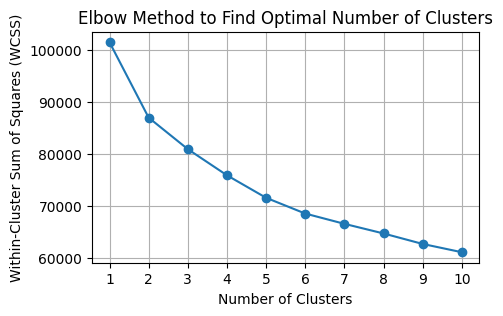

In [9]:
# feature engineering
xtrain_0 = feat_eng_2(xl_train)

from sklearn.cluster import KMeans

find_optimal_clusters(xtrain_0)

In [10]:
clus = KMeans(n_clusters=5, random_state=10)
clus.fit(xtrain_0)
cluster = Data_clusterer(clus)
xtrain_1 = cluster.transform(xtrain_0)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(xtrain_1)

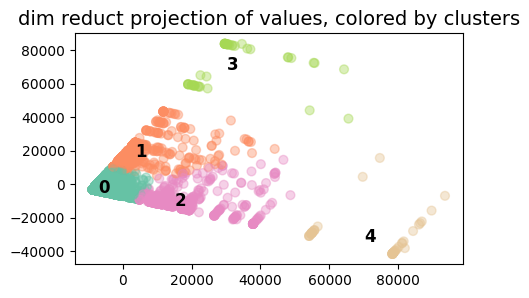

In [12]:
plot_clusters(xtrain_1.cluster, X_pca)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
xtrain_2 = scaler.fit_transform(xtrain_1)

#### 3. check cross val

Fit time mean: 0.5877353191375733
Score time mean: 0.022125387191772462
Test score: [0.85897436 0.83974359 0.83076923 0.84102564 0.83846154]
Test mean score: 0.8417948717948718


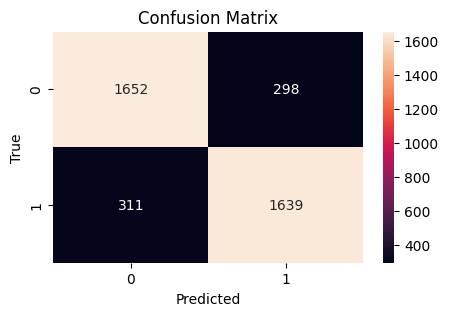

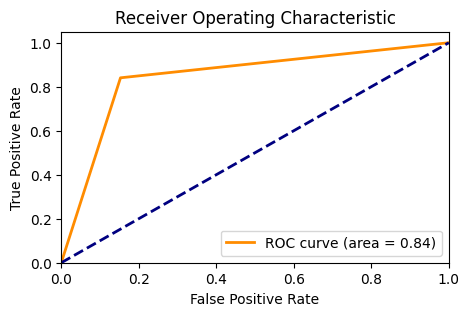

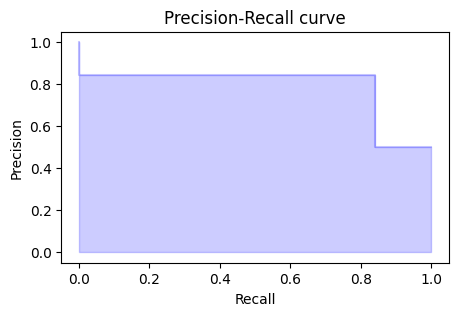

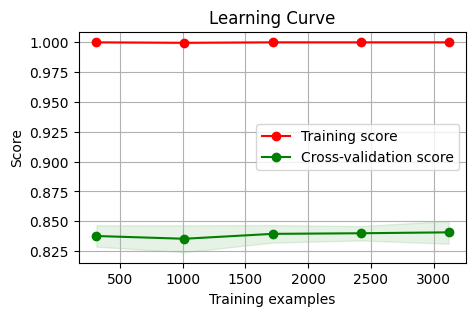

In [14]:
from sklearn.ensemble import RandomForestClassifier

cross_val(RandomForestClassifier(), xtrain_2, yl_train.replace({'loss':-1,'win':1}), cv=5)

Fit time mean: 0.5755844116210938
Score time mean: 0.1496811866760254
Test score: [0.84102564 0.81666667 0.82051282 0.83076923 0.83846154]
Test mean score: 0.8294871794871795


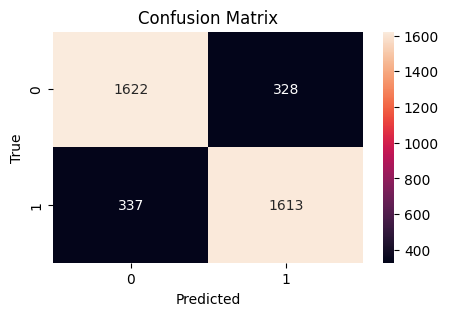

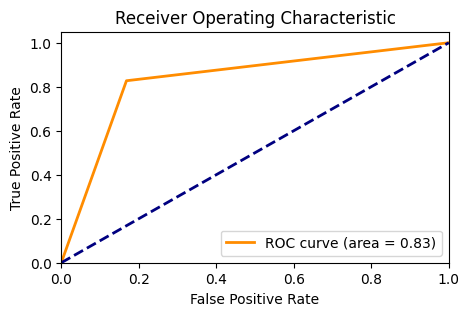

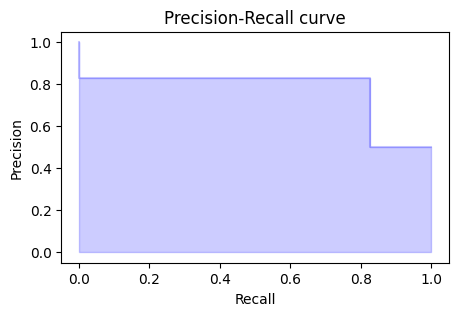

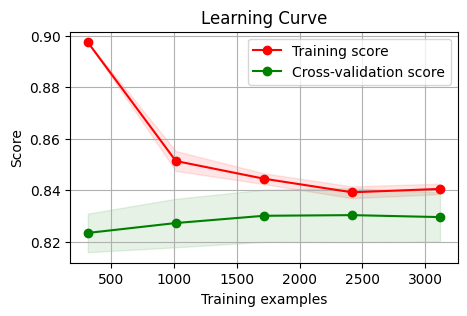

In [15]:
from sklearn.svm import SVC

cross_val(SVC(), xtrain_2, yl_train.replace({'loss':-1,'win':1}), cv=5)

#### 4. val and test metrics

In [27]:
cluster, scaler, model, xtrain_cluster, model_obj = model_trainer(xtrain, ytrain, feat_eng_2,
              KMeans(n_clusters=5, random_state=10),
              StandardScaler(), RandomForestClassifier())

In [28]:
xval_0 = feat_eng_2(xval)
xval_clus = cluster.transform(xval_0)
xval_scal = scaler.transform(xval_clus)
yval_pred = model_obj.transform(xval_scal)

In [29]:
!wget https://raw.githubusercontent.com/hundredblocks/ml-powered-applications/master/ml_editor/model_evaluation.py
from model_evaluation import get_metrics, get_confusion_matrix_plot, get_roc_plot,\
get_calibration_plot, get_feature_importance

--2023-09-23 00:27:16--  https://raw.githubusercontent.com/hundredblocks/ml-powered-applications/master/ml_editor/model_evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8593 (8.4K) [text/plain]
Saving to: ‘model_evaluation.py’

model_evaluation.py 100%[===================>]   8.39K  --.-KB/s    in 0s      

2023-09-23 00:27:16 (97.6 MB/s) - ‘model_evaluation.py’ saved [8593/8593]



In [30]:
get_metrics(yval_pred.boxer1_pred, yval)

(0.8528347406513872,
 0.8530011631681848,
 0.8528347406513872,
 0.8528173933290646)

In [31]:
feature_names = xtrain_cluster.columns
k = 10

print("Top %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(model, feature_names)[:k]]))

print("\nBottom %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(model, feature_names)[-k:]]))

Top 10 importances:

b1_more_fame: 0.18
len_text_boxer1: 0.16
len_text_boxer2: 0.14
b1_wk: 0.046
b1_bet_inversa: 0.046
b2_bet_inversa: 0.045
b2_wk: 0.044
b2_w: 0.04
b1_w: 0.04
b1_l: 0.026

Bottom 10 importances:

b1_mas_win_perc: 0.014
b1_menos_win_perc: 0.012
b1_menos_ko_perc: 0.011
b1_mas_ko_perc: 0.011
b1_menos_peleas: 0.0082
b1_mas_peleas: 0.0065
b1_menos_loss_perc: 0.0054
b1_mas_loss_perc: 0.0047
b2_invicto: 0.0035
b1_invicto: 0.0033


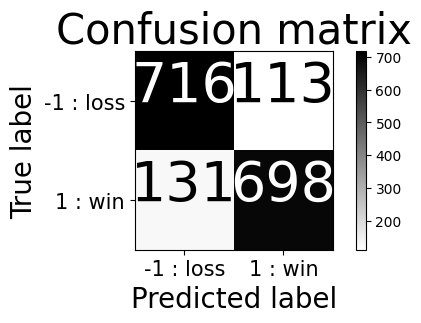

In [32]:
get_confusion_matrix_plot(yval_pred.boxer1_pred, yval,
                          figsize=(5, 3), classes=['-1 : loss','1 : win'])

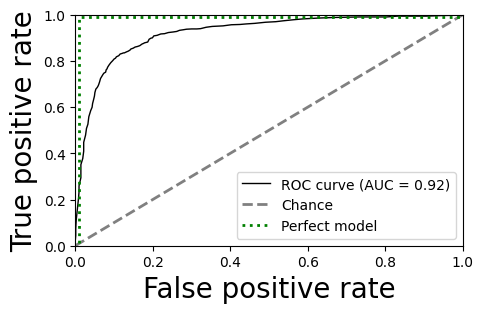

In [33]:
get_roc_plot(yval_pred.prob_win, yval.replace({'loss':-1,'win':1}), figsize=(5,3))

	Brier: 0.109


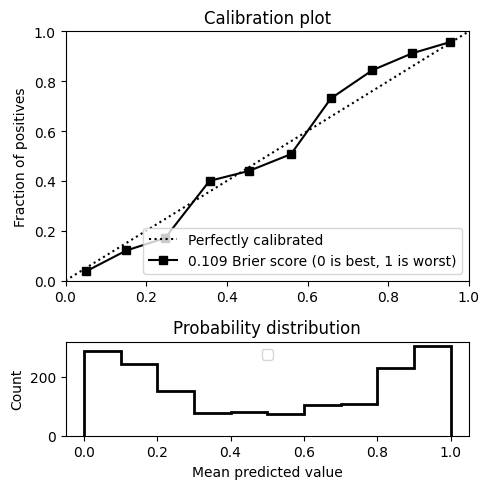

In [34]:
get_calibration_plot(yval_pred.prob_win, yval.replace({'loss':-1,'win':1}), figsize=(5, 5))

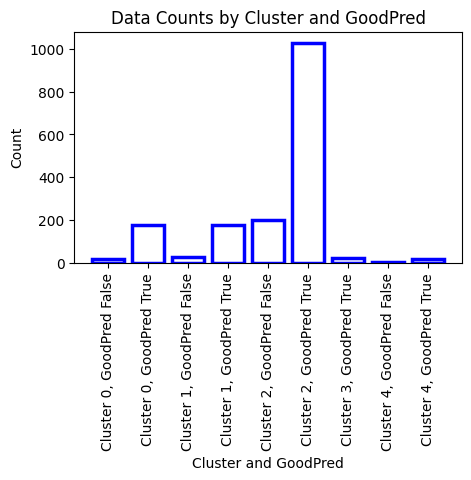

Porcentaje de False per Trues by clusters
cluster
0    0.108571
1    0.149425
2    0.192420
3    0.000000
4    0.062500
dtype: float64


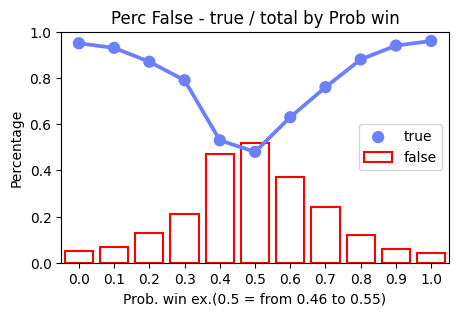

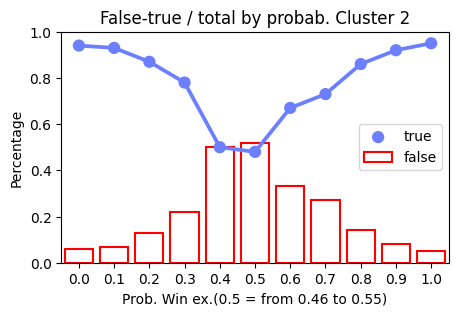

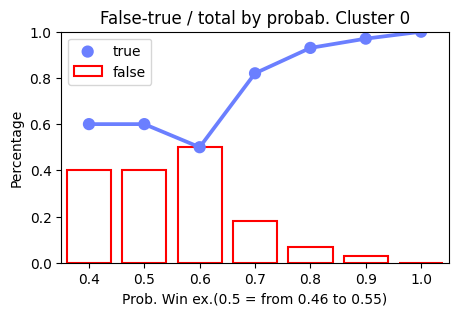

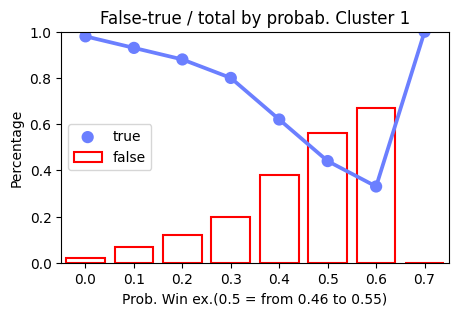

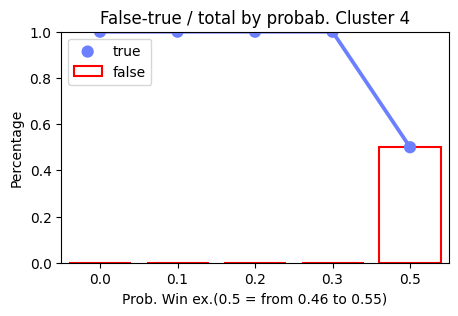


::: Attribute error in cluster: 3 :::



In [35]:
temp = check_fails_and_probas(xval_clus, yval, yval_pred.boxer1_pred, yval_pred.prob_loss, yval_pred.prob_win)

#### 5. hyperparams

In [36]:
x_0 = feat_eng_2(xtrain)
cluster = KMeans(n_clusters=5, random_state=10)
x_clus = cluster.fit_transform(x_0)
scaler = StandardScaler()
x_scal = scaler.fit_transform(x_clus)

In [37]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': np.arange(10, 200, 10),  # Number of trees in the forest
    'max_depth': np.arange(1, 20),          # Maximum depth of each tree
    'min_samples_split': np.arange(2, 11),  # Minimum samples required to split an internal node
    'min_samples_leaf': np.arange(1, 11),   # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider for the best split
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf_classifier,          # The model to tune
    param_distributions=param_grid,  # The parameter grid to search over
    n_iter=50,               # Number of parameter settings to sample
    cv=5,                    # Cross-validation folds
    n_jobs=-1                # Use all available CPU cores
)

# Perform the random search
random_search.fit(x_scal, ytrain)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Accuracy: {:.2f}%".format(random_search.best_score_ * 100))

Best Hyperparameters:  {'n_estimators': 140, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 4}
Best Accuracy: 83.24%


Fit time mean: 0.8254220485687256
Score time mean: 0.028531646728515624
Test score: [0.85512821 0.82564103 0.82820513 0.84230769 0.84487179]
Test mean score: 0.8392307692307692


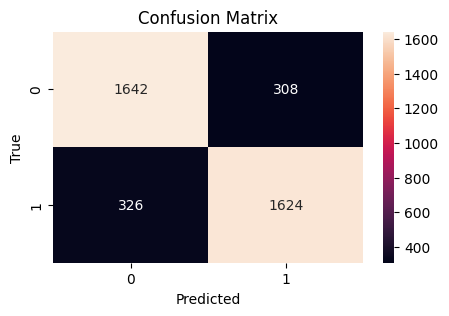

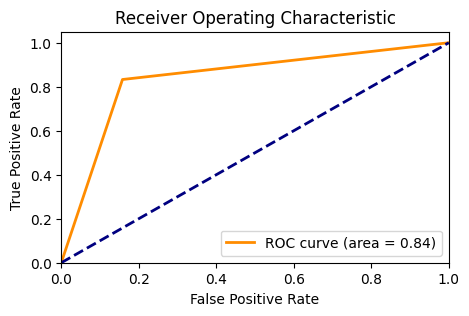

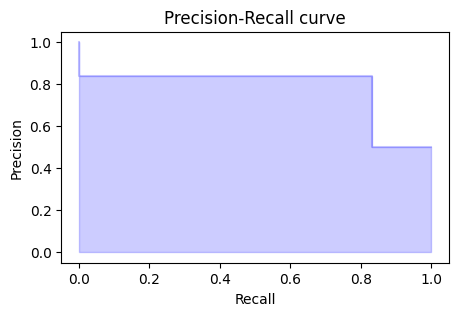

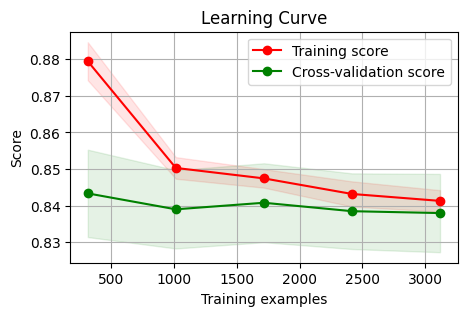

In [38]:
cross_val(RandomForestClassifier(n_estimators=190,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 max_features='sqrt',
                                 max_depth=4),
          xtrain_2, yl_train.replace({'loss':-1,'win':1}), cv=5)

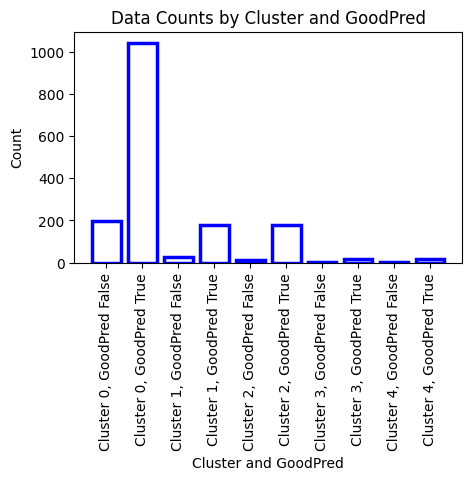

Porcentaje de False per Trues by clusters
cluster
0    0.187919
1    0.156425
2    0.073864
3    0.055556
4    0.058824
dtype: float64


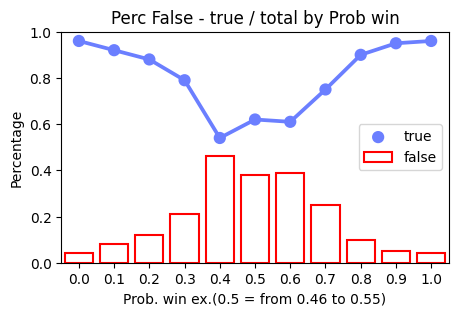

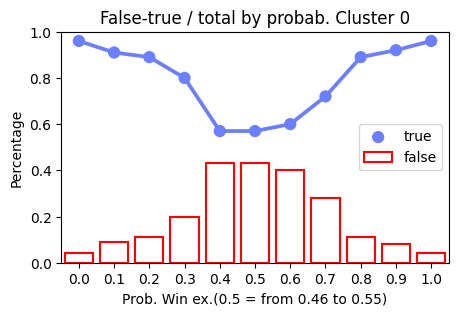

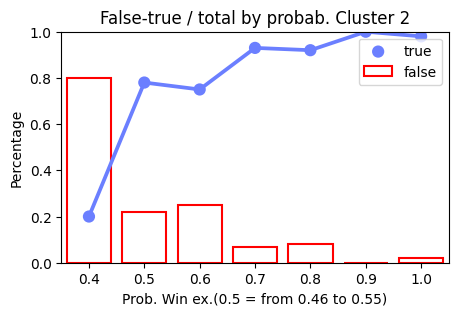

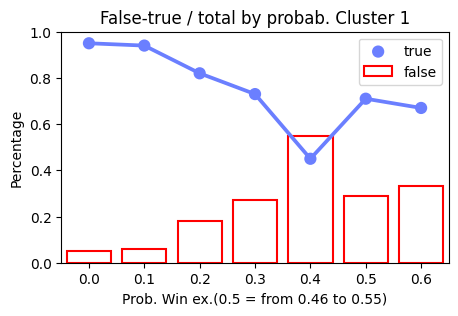

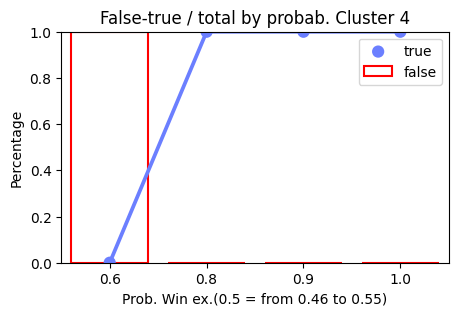

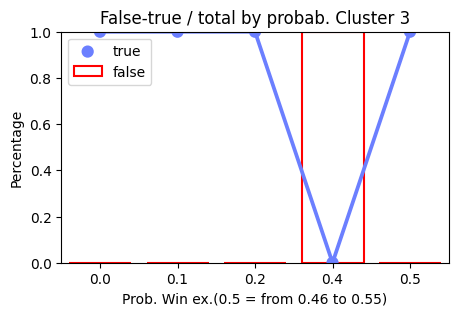

In [39]:
## no hyper
# entrenar
cluster, scaler, model, xtrain_cluster, model_obj = model_trainer(xl_train, yl_train, feat_eng_2,
              KMeans(n_clusters=5, random_state=10),
              StandardScaler(), RandomForestClassifier())

# predecir
xl_0 = feat_eng_2(xl_test)
xl_clus = cluster.transform(xl_0)
xl_scal = scaler.transform(xl_clus)
yl_pred = model_obj.transform(xl_scal)

# check
temp = check_fails_and_probas(xl_clus, yl_test, yl_pred.boxer1_pred, yl_pred.prob_loss, yl_pred.prob_win)

In [40]:
get_metrics(yl_pred.boxer1_pred, yl_test)

(0.8570574162679426,
 0.8572828600267735,
 0.8570574162679426,
 0.8570348636903371)

Top 10 importances:

b1_more_fame: 0.2
len_text_boxer1: 0.16
len_text_boxer2: 0.14
b2_bet_inversa: 0.046
b1_wk: 0.046
b1_bet_inversa: 0.045
b2_wk: 0.043
b2_w: 0.041
b1_w: 0.04
b1_l: 0.026

Bottom 10 importances:

cluster: 0.016
b1_mas_win_perc: 0.012
b1_menos_ko_perc: 0.011
b1_mas_ko_perc: 0.01
b1_menos_peleas: 0.0064
b1_mas_peleas: 0.0056
b1_mas_loss_perc: 0.0051
b1_menos_loss_perc: 0.0047
b1_invicto: 0.0031
b2_invicto: 0.003


	Brier: 0.109


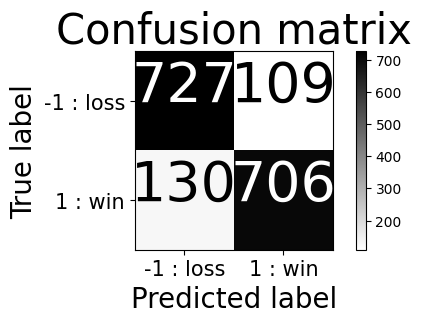

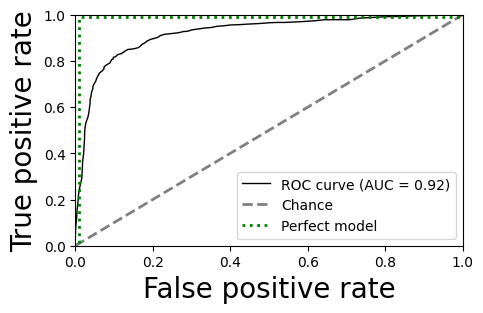

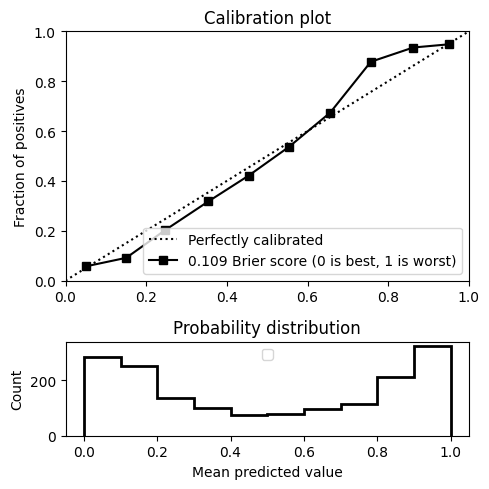

In [41]:
feature_names = xl_clus.columns
k = 10
print("Top %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(model, feature_names)[:k]]))
print("\nBottom %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(model, feature_names)[-k:]]))
get_confusion_matrix_plot(yl_pred.boxer1_pred, yl_test,
                          figsize=(5, 3), classes=['-1 : loss','1 : win'])
get_roc_plot(yl_pred.prob_win, yl_test.replace({'loss':-1,'win':1}), figsize=(5,3))
get_calibration_plot(yl_pred.prob_win, yl_test.replace({'loss':-1,'win':1}), figsize=(5, 5))

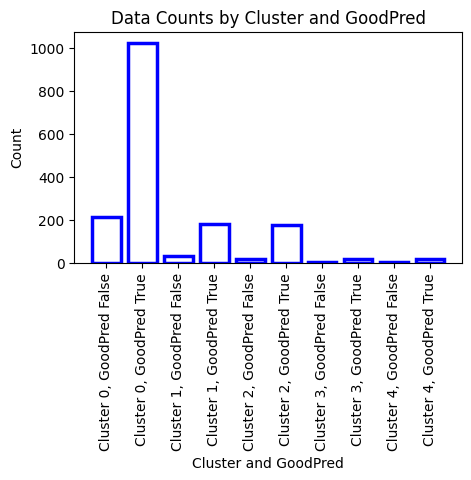

Porcentaje de False per Trues by clusters
cluster
0    0.208780
1    0.162921
2    0.086207
3    0.055556
4    0.058824
dtype: float64


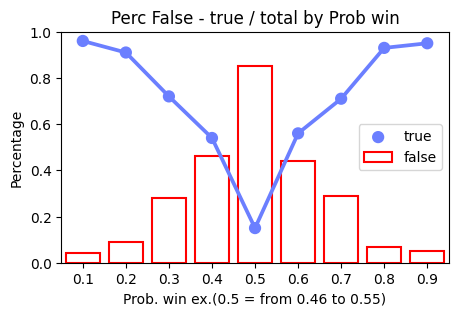

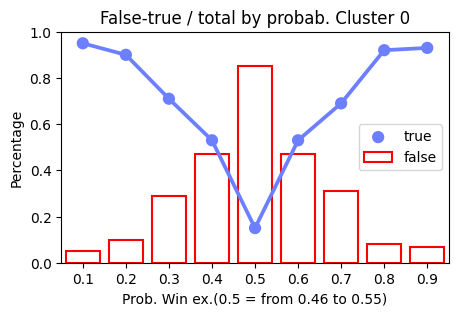

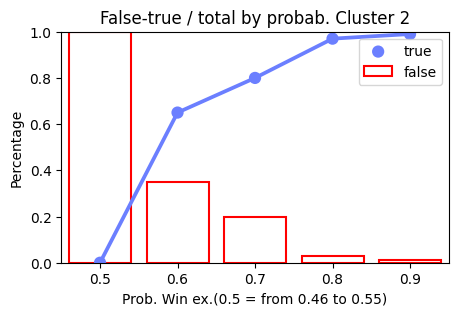

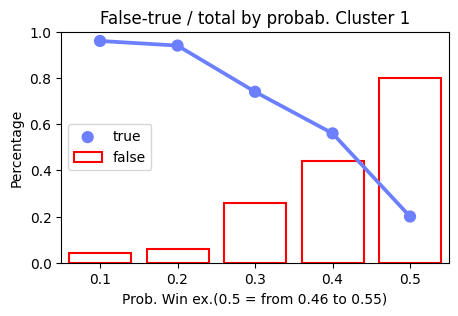

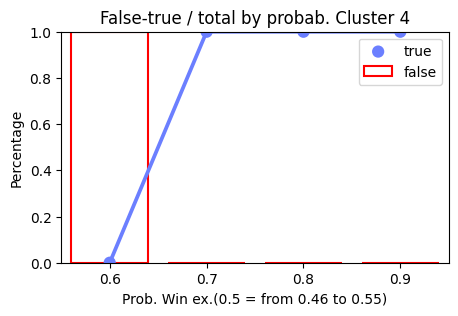

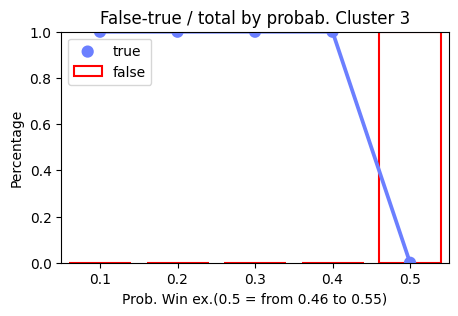

In [42]:
## hyper
# entrenar
cluster_hype, scaler_hype, model_hype, xtrain_cluster_hype, model_obj_hype = model_trainer(xl_train, yl_train, feat_eng_2,
              KMeans(n_clusters=5, random_state=10),
              StandardScaler(), RandomForestClassifier(n_estimators=190,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 max_features='sqrt',
                                 max_depth=4))

# predecir
xl_0 = feat_eng_2(xl_test)
xl_clus = cluster_hype.transform(xl_0)
xl_scal = scaler_hype.transform(xl_clus)
yl_pred_hype = model_obj_hype.transform(xl_scal)

# check
temp = check_fails_and_probas(xl_clus, yl_test, yl_pred_hype.boxer1_pred, yl_pred_hype.prob_loss, yl_pred_hype.prob_win)

In [43]:
get_metrics(yl_pred_hype.boxer1_pred, yl_test)

(0.8444976076555024,
 0.8450030951234611,
 0.8444976076555024,
 0.8444406275048666)

Top 10 importances:

b1_more_fame: 0.38
len_text_boxer1: 0.24
len_text_boxer2: 0.17
b1_momios_menores: 0.036
b1_mas_win_perc: 0.028
cluster: 0.023
b1_menos_win_perc: 0.021
b1_wk: 0.021
b2_wk: 0.016
b2_bet_inversa: 0.012

Bottom 10 importances:

b1_menos_peleas: 0.0021
b1_menos_loss_perc: 0.0018
b1_l: 0.0016
b1_mas_loss_perc: 0.0014
b1_lk: 0.0012
b2_invicto: 0.00081
b2_lk: 0.00081
b1_d: 0.00069
b2_d: 0.00046
b1_invicto: 7.6e-05


	Brier: 0.114


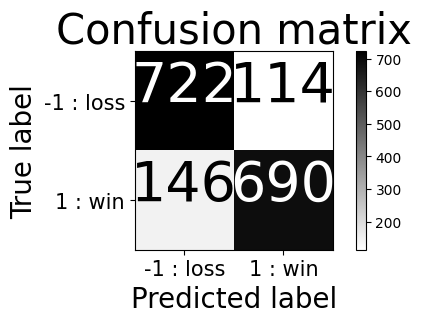

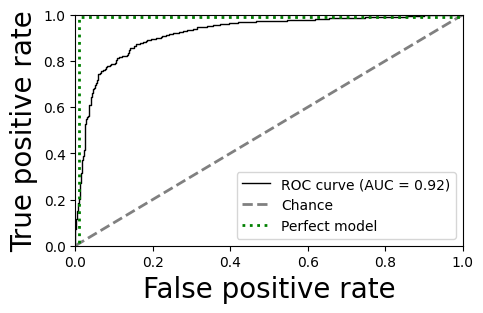

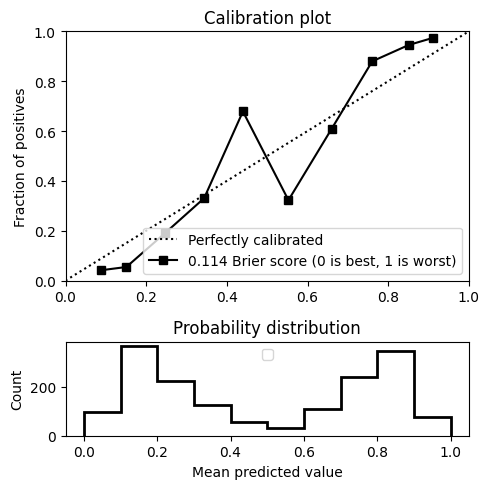

In [44]:
feature_names = xl_clus.columns
k = 10
print("Top %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(model_hype, feature_names)[:k]]))
print("\nBottom %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(model_hype, feature_names)[-k:]]))
get_confusion_matrix_plot(yl_pred_hype.boxer1_pred, yl_test,
                          figsize=(5, 3), classes=['-1 : loss','1 : win'])
get_roc_plot(yl_pred_hype.prob_win, yl_test.replace({'loss':-1,'win':1}), figsize=(5,3))
get_calibration_plot(yl_pred_hype.prob_win, yl_test.replace({'loss':-1,'win':1}), figsize=(5, 5))

Conclusión: Conservaré el modelo sin hyperparametros modificados

#### test new data

training all data

In [56]:
cluster, scaler, model, xtrain_cluster, model_obj = model_trainer(x, y,
              feat_eng_2,
              KMeans(n_clusters=5, random_state=10),
              StandardScaler(), RandomForestClassifier())

In [67]:
import joblib

# Save the trained model to a file
model_filename = 'box_model_object_ranfor.pkl'
joblib.dump(model_obj, model_filename)

model_filename = 'box_model_ranfor.pkl'
joblib.dump(model, model_filename)

model_filename = 'box_cluster_kmeans.pkl'
joblib.dump(cluster, model_filename)

model_filename = 'box_scaler_standard.pkl'
joblib.dump(scaler, model_filename)

['box_scaler_standard.pkl']

new predictions

In [57]:
df = pd.read_csv('/content/drive/MyDrive/data_science_machine_learning/project_box_data_science/new_data_box_reg/actualized_box_reg_data.csv')

In [58]:
df = df[['result','endtype','endround','boxer1','boxer2',
           'b1_w','b1_wk','b1_d','b1_l','b1_lk','b1_bet','len_text_boxer1',
           'b2_w','b2_wk','b2_d','b2_l','b2_lk','b2_bet','len_text_boxer2']]

y_inic = df[['result','endround','endtype']]
pelea = df[['boxer1','boxer2']]
x_inic = df.drop(columns=['result','endround','endtype','boxer1','boxer2'])

y_real = y_inic.result.copy()
x_real = x_inic.copy()

In [59]:
yreal_pred = new_pred_2(x_real, feat_eng_2, cluster, scaler, model_obj)
predictions = pd.concat([y_inic, pelea, yreal_pred], axis=1)

check results

In [60]:
predictions[predictions.result.isna()].iloc[:10, 3:]

,boxer1,boxer2,boxer1_pred,prob_win,cluster,reliability,data_amount,prob_loss,initial_index
1,canelo alvarez,jermell charlo,win,0.71,3,nunca se equivoco,"muy poca data (19 data clus, 1672 data total, ...",0.29,1
2,tyson fury,francis ngannou,win,0.93,3,nunca se equivoco,"muy poca data (19 data clus, 1672 data total, ...",0.07,2
5,robson conceicao,humberto galindo,win,0.99,1,no medido,"poca data (207 data clus, 1672 data total, 12 %)",0.01,5
7,clay aj waterman,kareem hackett,loss,0.42,1,"fiable, acierta en + de 70 %","poca data (207 data clus, 1672 data total, 12 %)",0.58,7
8,batyrzhan jukembayev,hugo alberto roldan,win,0.60,1,"fiable, acierta en + de 70 %","poca data (207 data clus, 1672 data total, 12 %)",0.40,8
9,aloys youmbi,erik nazaryan,loss,0.30,1,"fiable, acierta en + de 70 %","poca data (207 data clus, 1672 data total, 12 %)",0.70,9
10,ezra taylor,joel mclntyre,win,0.89,1,no medido,"poca data (207 data clus, 1672 data total, 12 %)",0.11,10
11,zach parker,khalid graidia,win,0.89,1,no medido,"poca data (207 data clus, 1672 data total, 12 %)",0.11,11
12,pierce oleary,kane gardner,loss,0.46,1,"fiable, acierta en + de 70 %","poca data (207 data clus, 1672 data total, 12 %)",0.54,12
13,moses itauma,amine boucetta,win,0.63,1,"fiable, acierta en + de 70 %","poca data (207 data clus, 1672 data total, 12 %)",0.37,13
